### LSTM Model Loop with Skill Score calculation

File recreated on 7/31/2025.

I will start with a 14 day model. 

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
import random
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import TimeSeriesSplit
import xarray as xr

import pickle

import warnings
warnings.filterwarnings("ignore")

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

import shap
import pylab
#tf.compat.v1.disable_eager_execution()
#import investigate

2026-01-19 15:56:52.017387: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-19 15:56:52.060869: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-19 15:56:52.060898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-19 15:56:52.061916: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-19 15:56:52.068276: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from StatScores import BSS
from StatScores import RAS_two
from StatScores import PAS_two

### Inputs.

In [3]:

#load input data, it is max/min standardized, NaNs removed
#stratospheric polar vortex ellipse diagnostics from Fernandez et al 2025 (in review)
#comparison here may be a little muddled because I am limitied in the days that I can observe, however, I am currently working(7/8/2025) on calculating the diagnostics for the full dataset
#this will be fixed. 

infile = open("../data/nolag_extendedanom_SEPARATED.p", 'rb') 
nolag_input = pickle.load(infile)
infile.close()

idx = 149
#switch to 149 for normal. 

inp1 = np.empty((62,idx,8)) #create new input array, 14 day lag. 

shift = 0
#0 if normal
#this indicates setting the start date as November 2 rather than October 19

##reshaping to change lag in metrics for input
inp1[:,:,0] = nolag_input[:62,shift:,0] ##wind
inp1[:,:,1] = nolag_input[:62,shift:,1] ##ratio
inp1[:,:,2] = nolag_input[:62,shift:,2] ##latitude
inp1[:,:,3] = nolag_input[:62,shift:,3] ##longitude
inp1[:,:,4] = nolag_input[:62,shift:,4] ##size
inp1[:,:,5] = nolag_input[:62,shift:,5] ##ephi
inp1[:,:,6] = nolag_input[:62,shift:,6] ##gph
inp1[:,:,7] = nolag_input[:62,shift:,7] ##pv

inp=inp1.reshape(62*idx,8)
inp.shape

(9238, 8)

In [4]:
#convert to pandas dataframe
input = pd.DataFrame(inp)
#label columns of variables for input data
col_names = ['wind','rat','cenlat','cenlon','size','ephi','gph','pv']
input.columns = col_names

input

,wind,rat,cenlat,cenlon,size,ephi,gph,pv
0,0.464008,0.642905,0.932911,0.014659,0.168590,0.762357,0.735719,0.845671
1,0.466708,0.651586,0.930048,0.517315,0.172985,0.770792,0.737937,0.858727
2,0.470759,0.654339,0.926142,0.656929,0.183382,0.770998,0.743380,0.905760
3,0.476072,0.646157,0.923356,0.718249,0.193405,0.781390,0.742553,0.946831
4,0.480682,0.640435,0.923270,0.749873,0.202811,0.797401,0.738502,0.945741
...,...,...,...,...,...,...,...,...
9233,0.550217,0.137406,0.687848,0.757728,0.583735,0.205300,0.557894,0.303037
9234,0.542128,0.133433,0.681445,0.772004,0.570213,0.215420,0.550957,0.308571
9235,0.538114,0.126583,0.676384,0.790511,0.551703,0.236622,0.551418,0.306792
9236,0.537360,0.117930,0.673090,0.812203,0.532506,0.280782,0.560904,0.311106


In [5]:
##change pandas dataframe to choose top 5 important features only
inp = input[['gph', 'cenlat', 'cenlon', 'wind', 'pv', 'size', 'rat']]

In [6]:
inp2 = inp.values.reshape(62,149,7)
inp2.shape

(62, 149, 7)

### Outputs. 

In [7]:
#load output data file.
#I can change this to represent any of the available temp regions. 
infile = open("../data/eur_anomtemps_reduced.p","rb",)
output = pickle.load(infile) 
infile.close()

In [8]:
# load climo data
infile = open("../data/eur_climoprob_reduced.p","rb",)
climo = pickle.load(infile) 
infile.close()

In [9]:
##need to change this based on lag 
## 14-days = [:, 10:] 10 day window rather than 14
## 20-days = [:, 16:]
## 30-days = [:, 26:]

# 139
# 133
# 123

## 14-days = [:, 14:] 14 day window
## 20-days = [:, 20:]
## 30-days = [:, 30:]

# 135
# 129
# 119

lead = 135

temp = output.reshape(62, 149)
temp = temp[:, 14:]

climo = climo.reshape(62, 149,2)
climo = climo[:, 14:, :]
#climo = climo.reshape(8370,2)

print("input: ",inp2.shape)
print("climo: ",climo.shape)
print("output: ",temp.shape)

input:  (62, 149, 7)
climo:  (62, 135, 2)
output:  (62, 135)


In [10]:
#create timeseries data arrays for PCs 
#was 122 and 14 for the 14 day window. 

new_input =  np.empty((62,lead,14,7))
new_output = np.empty((62,lead))
new_climo = np.empty((62,lead,2))

for i in range(0,62):
    for j in range(0,lead):
        new_input[i,j,:,:] = inp2[i,j:j+14,:]
        new_output[i,j] = temp[i,j]
        new_climo[i,j] = climo[i,j,:]

In [11]:
new_input = np.array(new_input)
new_climo = np.array(new_climo.reshape(62*lead,2))
new_output = np.array(new_output)

print("input: ",new_input.shape)
print("climo: ",new_climo.shape)
print("output: ",new_output.shape)

input:  (62, 135, 14, 7)
climo:  (8370, 2)
output:  (62, 135)


In [12]:
##Set X_all and Y_all datasets
frac_end = (52*lead)
frac_ind = (10*lead)

X_all = np.copy(new_input.reshape((62*lead),14,7))
Y_all = np.copy(new_output.flatten())

##training data partition out
X_tri = X_all[:frac_end,:]
Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes = X_all[frac_end:,:]
Y_tes = Y_all[frac_end:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

print(Y_all.shape)

(8370, 2)


In [13]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [14]:
##number of input nodes
numb_int = X_all.shape[1:]
#this defines the 2-d shape used by the lstm model.
print("shape of lstm input: ",numb_int)

shape of lstm input:  (14, 7)


In [15]:
########
#CHANGE BASED ON NUMBER OF FOLDS FOR TIMESERIES SPLIT

repeat = 2
split = 7

#n = repeat*split
n = 100

In [16]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [17]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [18]:
##Loss and ACC lists, only relevant w/o early stopping
train_loss = []
val_loss = []
cat_acc = []
val_acc = [] 

##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((n,))
BSS_val= np.empty((n,))
BSS_train= np.empty((n,))
BSS_test= np.empty((n,))
BSS_90= np.empty((n,))

BSS_avg= np.empty((n,))
BSS_30= np.empty((n,))
BSS_70= np.empty((n,))

##RAS and PAS Arrays
Prec_all= np.empty((n,2))
Rec_all= np.empty((n,2))

Prec_val= np.empty((n,2))
Rec_val= np.empty((n,2))

Prec_train= np.empty((n,2))
Rec_train= np.empty((n,2))

Prec_test= np.empty((n,2))
Rec_test= np.empty((n,2))

##FOR SHAP
cat_shaps = np.empty((n,2,7))
class0_agg = np.empty((n,300,7))
class1_agg = np.empty((n,300,7))
shap_out = np.empty((n,300,14,7,2))

In [19]:
##empty lists for ACC scores 
##Testing Accuracy Arrays
fulltest_acc = []
test90_acc = []

##Training Accuracy Arrays
fulltrain_acc = []
train90_acc = []

##Validation Accuracy Arrays
fullval_acc = []
val90_acc = []

In [20]:
##probabilities
p_test = []
p_train = []
p_val = []

p_mid = []
p_90 = []
p_30 = []
p_70 = []

##correct positive
posXtest = []
#false positive
FposXtest = []
#correct negative
negXtest = []
#false negative
FnegXtest = []

index90 = []
indexmin = []
indexmid = []
indexmax = []

##correct positive
percpos = []
#false positive
percFpos = []
#correct negative
percneg = []
#false negative
percFneg = []

### Model Architecture. 

In [21]:
######
batch_size = 64
epochs = 30
shuffle = True
verbose = 0 #0 returns no apoch info, 2 does

In [22]:
#model
def basic_LSTM(ntimestep, nfeature, n1, n2, n3, rl1, rl2, rl3, lr):  
    input_tensor = Input(shape=(ntimestep, nfeature))
    
    layer1 = layers.RNN(
        layers.LSTMCell(n1, activation='tanh', use_bias=True,
                          dropout=0.331, 
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1)),
        return_sequences=True)(input_tensor)
       
    layer2 = layers.RNN(
        layers.LSTMCell(n2, activation='tanh', use_bias=True,
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl2)),
        return_sequences=False)(layer1)
    
    layer3 = layers.Dense(n3, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl3))(layer2)

    output_tensor = layers.Dense(2, activation='softmax',)(layer3)

    model = Model(input_tensor, output_tensor)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    loss = 'categorical_crossentropy' #categorical_focal_loss(alpha=0.7, gamma=0.5)
    #decay_rate = lr / epochs
    #momentum = 0.9

    model.compile(optimizer=opt,loss=loss,metrics=[keras.metrics.categorical_accuracy],)
                            
    return model

In [23]:
##Early Stopping Condition, if desired
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=1)

In [24]:
## create loop for cross validation
for l in range(0,n):
    print("#######################################")
    print("CV ",l)
    tf.keras.backend.clear_session()
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_tri[:,0])-frac_ind)
    end = start+(frac_ind)

    #choose random 15% window of training data to be used for validation
    X_val = X_tri[start:end]
    Y_val = Y_tri[start:end]

    #remaining training data
    X_train1 = X_tri[0:start]
    Y_train1 = Y_tri[0:start]
    X_train2 = X_tri[end:]
    Y_train2 = Y_tri[end:]
    ##concatenate all of these
    X_tr = np.concatenate((X_train1,X_train2))
    Y_tr = np.concatenate((Y_train1,Y_train2))
    
    ##calculate class weights on remaining training data
    class_weight = class_weight_creator(Y_tr)
    #class_weight = {0 : 1.0, 1 : 1.79}
    
    
    ##same partitioning for climo data
    climo_train1 = new_climo[0:start,:]
    climo_train2 = new_climo[end:frac_end,:]
    
    climo_train = np.concatenate((climo_train1,climo_train2))
    
    ##pause, calculate climo probabilities
    climo_val = new_climo[start:end,:]
    climo_test = new_climo[frac_end:,:]
    
    #initalize model
    model = basic_LSTM(numb_int[0],numb_int[1], 128, 14, 28, 0.03, 0.03, 0.06, 0.0009)

    model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val),
              batch_size=batch_size, epochs=epochs, shuffle=shuffle,
              class_weight = class_weight, verbose=verbose, callbacks=[early_stopping])
    
    train_loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    cat_acc.append(model.history.history['categorical_accuracy'])
    val_acc.append(model.history.history['val_categorical_accuracy'])
    
    pred = model.predict(X_all)
    pred_val = model.predict(X_val)
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_tes)
    
    p_train.extend(pred_train)
    p_val.extend(pred_val)
    p_test.extend(pred_test)
    ########################################################################################################
    ##STATISTICS CALCULATINNG
    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []
    
    ##BRIER SKILL SCORE
    BSS_all[l] = BSS(Y_all,pred)
    BSS_val[l] = BSS(Y_val,pred_val)
    BSS_train[l] = BSS(Y_tr,pred_train)
    BSS_test[l] = BSS(Y_tes,pred_test) 
    
    ##RECALL ACCURACY SCORE    
    RAS_two(l, Rec_all, new_climo, Y_all, pred, pred_class,
            climo_val, Rec_val, Y_val, pred_val, predval_class,
            climo_train, Rec_train, Y_tr, pred_train, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test, predtest_class)
    ##PRECISION ACCURACY SCORE     
    PAS_two(l, Prec_all, new_climo, Y_all, pred, pred_class,
            climo_val, Prec_val, Y_val, pred_val, predval_class,
            climo_train, Prec_train, Y_tr, pred_train, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test, predtest_class)
    ########################################################################################################
    ##ACC
    ##TESTING
    q90 = np.percentile(pred_test,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test90 = pred_test[great90]
    test90_norm = Y_tes[great90]
    if len(test90) == 0:
        test90_acc.append(np.nan)
        BSS_90[l] = np.nan
        p_90.extend([np.nan]*len(Y_tes[0]))
        percpos.append(np.nan)
        percFpos.append(np.nan)
        percneg.append(np.nan)
        percFneg.append(np.nan)
    else:
        test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
        fulltest_acc.append(calculate_accuracy(Y_tes, pred_test, threshold=0.5))

        BSS_90[l] = BSS(test90_norm,test90)
        p_90.extend(test90)

        correct_pos, correct_neg, false_pos, false_neg = [], [], [], []

        for j in range(len(great90)):
            index = great90[j]

            if pred_test[index, 1] > pred_test[index, 0] and Y_tes[index, 1] == 1:
                correct_pos.append(index)
            elif pred_test[index, 0] > pred_test[index, 1] and Y_tes[index, 0] == 1:
                correct_neg.append(index)
            elif pred_test[index, 1] > pred_test[index, 0] and Y_tes[index, 0] == 1:
                false_pos.append(index)
            elif pred_test[index, 0] > pred_test[index, 1] and Y_tes[index, 1] == 1:
                false_neg.append(index)

        posXtest.extend(correct_pos)
        FposXtest.extend(false_pos)
        negXtest.extend(correct_neg)
        FnegXtest.extend(false_neg)

        percpos.append(len(correct_pos)/len(great90))
        percFpos.append(len(false_pos)/len(great90))
        percneg.append(len(correct_neg)/len(great90))
        percFneg.append(len(false_neg)/len(great90))

        index90.extend(great90)


    ##############################3
    
    #AVERAGE QUANT
    qmin = np.min(pred_test,axis=0)
    q30 = np.percentile(pred_test,30,axis=0) ##30th percentile of test
    q70 = np.percentile(pred_test,70,axis=0) ##70th percentile of test
    qmax = np.max(pred_test,axis=0)
    
    ##mid percentile acc
    mid = [i for i, row in enumerate(pred_test) if (row[0] >= q30[0] and row[0] <= q70[0] ) or (row[1] >= q30[1] and row[1] <= q70[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test_mid = pred_test[mid]
    test_mid_norm = Y_tes[mid]
    
    if len(test_mid) == 0:
        BSS_avg[l] = np.nan
        p_mid.extend([np.nan]*len(Y_tes[0]))
    else:
        BSS_avg[l] = BSS(test_mid_norm,test_mid)
        p_mid.extend(test_mid)
    
    #0-30
    minimum = [i for i, row in enumerate(pred_test) if (row[0] >= qmin[0] and row[0] < q30[0] ) or (row[1] >= qmin[1] and row[1] < q30[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test_minimum = pred_test[minimum]
    test_minimum_norm = Y_tes[minimum]
    
    if len(test_minimum) == 0:
        BSS_30[l] = np.nan
        p_30.extend([np.nan]*len(Y_tes[0]))
    else:
        BSS_30[l] = BSS(test_minimum_norm,test_minimum)
        p_30.extend(test_minimum)
    
    #70-100
    maximum = [i for i, row in enumerate(pred_test) if (row[0] > q70[0] and row[0] <= qmax[0] ) or (row[1] > q70[1] and row[1] <= qmax[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test_maximum = pred_test[maximum]
    test_maximum_norm = Y_tes[maximum]
    
    if len(test_maximum) == 0:
        BSS_70[l] = np.nan
        p_70.extend([np.nan]*len(Y_tes[0]))
    else:
        BSS_70[l] = BSS(test_maximum_norm,test_maximum)
        p_70.extend(test_maximum)
    
    ####_______SAVE INDICES _______
    index90.extend(great90)
    indexmin.extend(minimum)
    indexmid.extend(mid)
    indexmax.extend(maximum)
    ##############################
    ####_________________SHAP_________________
    #use gradient explainer on subset of training data
    sample = X_tr[start:end]
    explainer = shap.GradientExplainer(model, sample)
    #use explainer
    shap_values = explainer.shap_values(X_tr[:300])

    shap_values = np.array(shap_values)
    shap_out[l,:,:,:,:] = shap_values
    aggs = np.abs(shap_values) ##aggregate over the samples to make all positive
    #take mean along sample dimension
    aggs = aggs.mean(axis=0)
    feat_cat = aggs.mean(axis=0) ##take mean along timestep axis
    feat_cat = feat_cat.reshape(2,7)
    cat_shaps[l,:,:] = feat_cat[:,:] ##APPEND TO BIG ARRAY. 

    #stuff for creating beeswarm plots
    shap_class1_agg = np.mean(shap_values[:,:,:,1], axis=1)  #pos class agg shap values (samples, features)
    shap_class0_agg = np.mean(shap_values[:,:,:,0], axis=1)  #neg class agg shap values (samples, features)

    class0_agg[l,:,:] = shap_class0_agg[:,:]
    class1_agg[l,:,:] = shap_class1_agg[:,:]

#######################################
CV  0
Restoring model weights from the end of the best epoch: 22.
Epoch 27: early stopping
43/43 [==============================] - 0s 5ms/step
#######################################
CV  1
Restoring model weights from the end of the best epoch: 22.
Epoch 27: early stopping
43/43 [==============================] - 0s 5ms/step
#######################################
CV  2
Restoring model weights from the end of the best epoch: 14.
Epoch 19: early stopping
43/43 [==============================] - 0s 5ms/step
#######################################
CV  3
Restoring model weights from the end of the best epoch: 19.
Epoch 24: early stopping
43/43 [==============================] - 0s 6ms/step
#######################################
CV  4
43/43 [==============================] - 0s 5ms/step
#######################################
CV  5
Restoring model weights from the end of the best epoch: 25.
Epoch 30: early stopping
43/43 [===========================

In [25]:
##correct positive
posXtest = np.array(posXtest)
#false positive
FposXtest = np.array(FposXtest)
#correct negative
negXtest = np.array(negXtest)
#false negative
FnegXtest = np.array(FnegXtest)

print(f'Average Num. of 10% Confident and Correct Postive Predictions: {np.nanmean(percpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and Correct Negative Predictions: {np.nanmean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Postive Predictions: {np.nanmean(percFpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Negative Predictions: {np.nanmean(percFneg)* 100:.2f}%')
print('#######################################################################')
print(f'Average Num. of 10% Confident and Correct Predictions: {np.nanmean(percpos)* 100 + np.nanmean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Predictions: {np.nanmean(percFpos)* 100 +np.nanmean(percFneg)* 100:.2f}%')

Average Num. of 10% Confident and Correct Postive Predictions: 37.15%
Average Num. of 10% Confident and Correct Negative Predictions: 31.34%
Average Num. of 10% Confident and FALSE Postive Predictions: 11.25%
Average Num. of 10% Confident and FALSE Negative Predictions: 20.27%
#######################################################################
Average Num. of 10% Confident and Correct Predictions: 68.49%
Average Num. of 10% Confident and FALSE Predictions: 31.51%


In [26]:
##export out files to make the next few plots w/o normalization
pickle.dump(posXtest, open("./index/posXtest_eur14.p", 'wb'))
pickle.dump(FposXtest, open("./index/FposXtest_eur14.p", 'wb'))
pickle.dump(negXtest, open("./index/negXtest_eur14.p", 'wb'))
pickle.dump(FnegXtest, open("./index/FnegXtest_eur14.p", 'wb'))

### Skill Score Distributions. 

### Percentile ACC Plots.

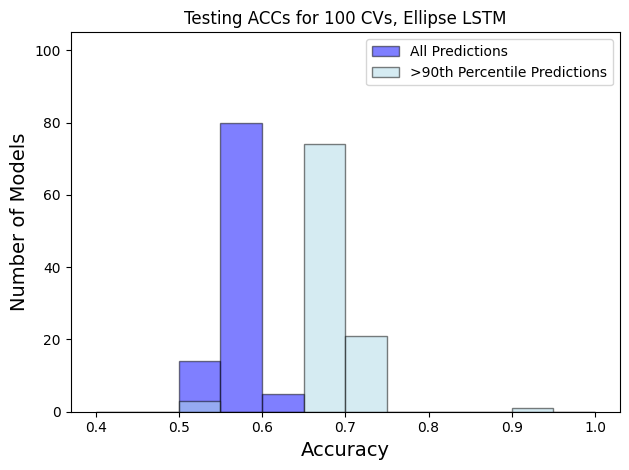

In [38]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
#plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')

#plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy',fontsize =14)
plt.ylabel('Number of Models',fontsize =14)
plt.ylim(0,105)
plt.legend()
plt.title(f'Testing ACCs for 100 CVs, Ellipse LSTM',fontsize =12)
plt.tight_layout()
#plt.title('Testing Prediction Accuracy Across 100 CVs for +14 day Europe Temp Anoms (LSTM)',fontsize =12,y=1.02)
plt.savefig("EUR14_ACCtesting.png",bbox_inches = 'tight')

### SHAP Plots.

In [28]:
shap_out.shape

(100, 300, 14, 7, 2)

In [29]:
test = np.mean(np.abs(shap_out[:, :, :, :, 0]), axis=(0,1))  
test.shape

(14, 7)

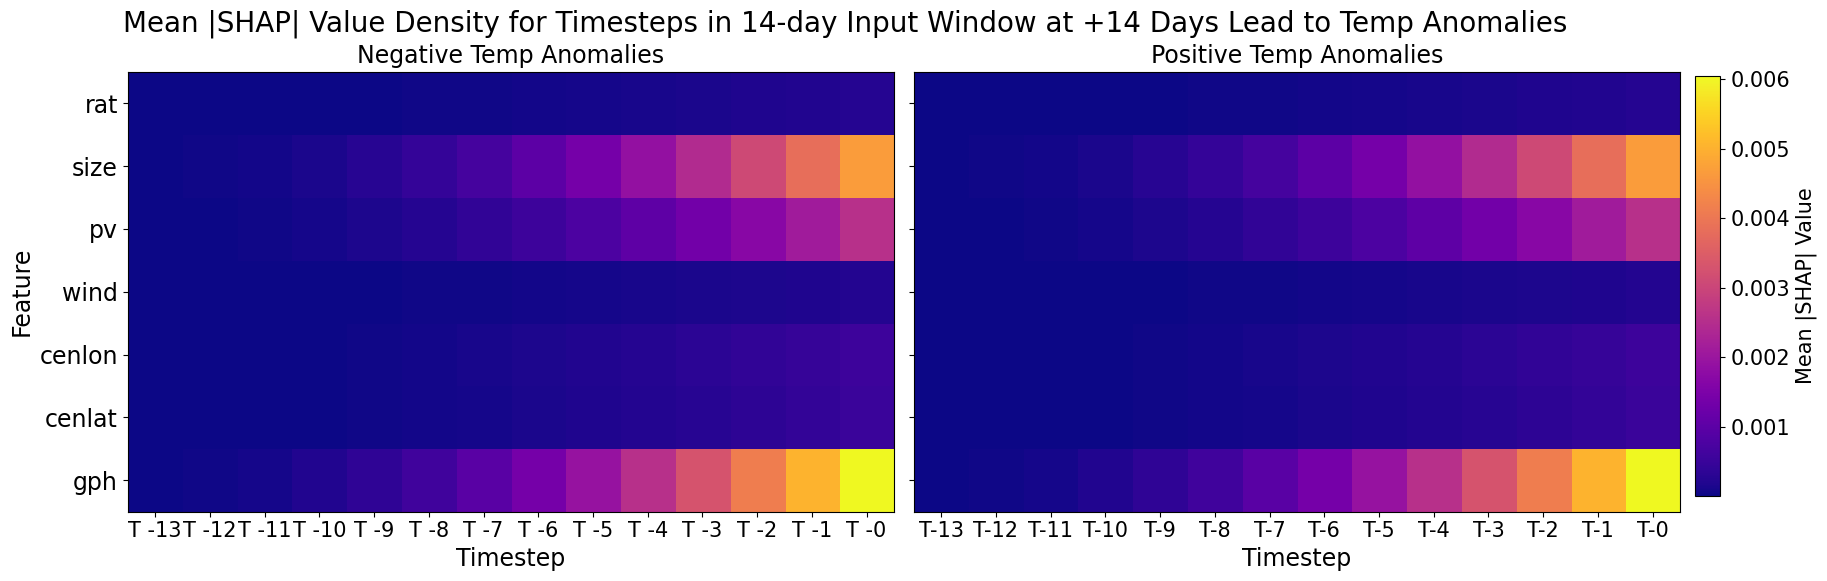

In [37]:
#compute mean |SHAP| over CVs and samples for each class separately
#computed along the cv axis and smaple axis
shap_class0 = np.mean(np.abs(shap_out[:, :, :, :, 0]), axis=(0,1))  
shap_class1 = np.mean(np.abs(shap_out[:, :, :, :, 1]), axis=(0,1)) 

#transpose bc features arent on yaxis
plot_class0 = shap_class0.T
plot_class1 = shap_class1.T

features =['gph', 'cenlat', 'cenlon', 'wind', 'pv', 'size', 'rat']

fig, axes = plt.subplots(1, 2, figsize=(17, 6), sharey=True)

plt.suptitle("Mean |SHAP| Value Density for Timesteps in 14-day Input Window at +14 Days Lead to Temp Anomalies", fontsize=20, y=0.96)
#neg temps subplot
im0 = axes[0].imshow(plot_class0, aspect='auto', cmap='plasma', origin='lower')
axes[0].set_title("Negative Temp Anomalies", fontsize=17)
axes[0].set_xlabel("Timestep", fontsize=17)
axes[0].set_ylabel("Feature", fontsize=17)
axes[0].set_xticks(np.arange(14))
axes[0].set_xticklabels([str("T -"+str(i)) for i in range(14)], fontsize=15)
axes[0].set_yticks(np.arange(7))
axes[0].set_yticklabels(features, fontsize=17)
axes[0].invert_xaxis()

#pos temps
im1 = axes[1].imshow(plot_class1, aspect='auto', cmap='plasma', origin='lower')
axes[1].set_title("Positive Temp Anomalies", fontsize=17)
axes[1].set_xlabel("Timestep", fontsize=17)
axes[1].set_xticks(np.arange(14))
axes[1].set_xticklabels([str("T-"+str(i)) for i in range(14)], fontsize=15)
axes[1].invert_xaxis()

fig.subplots_adjust(right=0.87)

cbar_ax = fig.add_axes([1, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Mean |SHAP| Value", fontsize=15)

plt.tight_layout()
plt.savefig("EUR14_SHAPdensity.png",bbox_inches = 'tight')
plt.show()

In [31]:
X_sample.shape

NameError: name 'X_sample' is not defined

In [32]:
#shap beeswarm, pre process
class0_agg = np.nanmean(class0_agg, axis=0)
class1_agg = np.nanmean(class1_agg, axis=0)
X_sample = np.mean(X_tr[:300], axis=1) #reference from training for agg shaps(samples, features)
#separate reference dataframe with column names. 
X_df = pd.DataFrame(X_sample, columns=features)

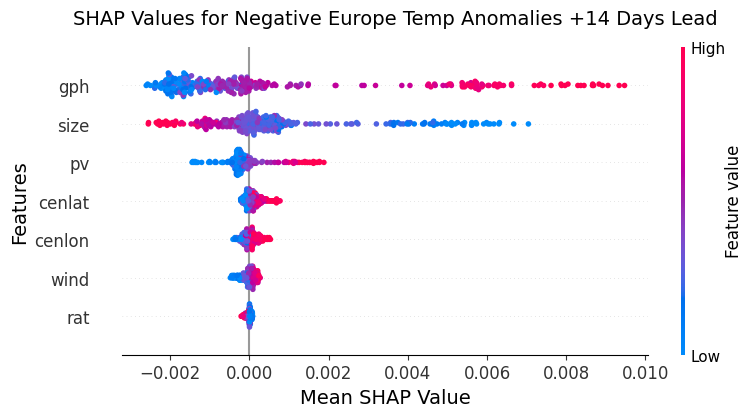

In [33]:
##Positive Beeswarm
shap.summary_plot(shap_class1_agg, X_df, show=False)
fig = plt.gcf()
ax = plt.gca()

fig.suptitle("SHAP Values for Negative Europe Temp Anomalies +14 Days Lead",fontsize =14, y = 0.96)
ax.set_xlabel("Mean SHAP Value", fontsize=14)
ax.set_ylabel("Features", fontsize=14)
#ax.set_xticks(np.arange(-0.015,0.02,0.01)) 
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
#plt.savefig("SHAP_beepos_eur14.png",bbox_inches = 'tight')
plt.show()

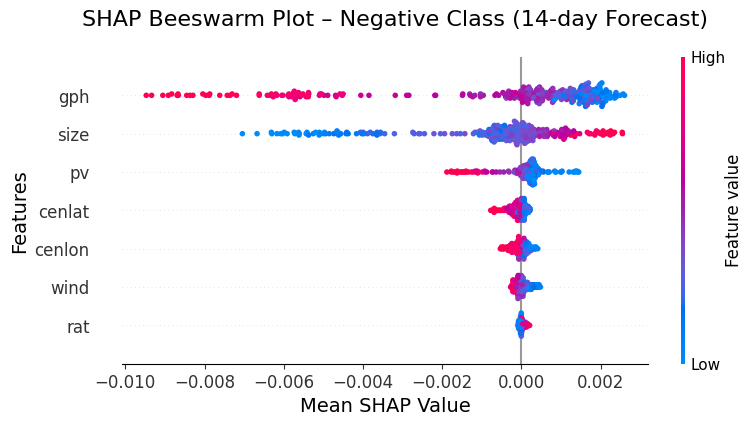

In [36]:
##negative beeswarm
shap.summary_plot(shap_class0_agg, X_df, show=False)
fig = plt.gcf()
ax = plt.gca()

fig.suptitle("SHAP Beeswarm Plot – Negative Class (14-day Forecast)", fontsize=16)
ax.set_xlabel("Mean SHAP Value", fontsize=14)
#ax.set_xticks(np.arange(-0.1,0.1,0.05)) 
ax.set_ylabel("Features", fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig("SHAP_beeneg_eur14.png")
plt.show()

In [35]:
## testing print avg BSS/RAS/PAS
def F1_score(RAS,PAS):
    F1 = np.nanmean(((2*RAS*PAS)/(RAS+PAS)))
    return F1
#___________________________________________#

print("_____________________________________________________________________")
print(f"Brier Skill Score (Test): {np.nanmean(BSS_test,axis=0):.4f}")
print("_____________________________________________________________________")
print("Recall and Precision: Neg Cat")
print("#########")
print(f"Recall Accuracy Score (Test): {np.nanmean(Rec_test[:,0],axis=0):.4f}")
print(f"Precision Accuracy Score (Test): {np.nanmean(Prec_test[:,0],axis=0):.4f}")
print(f"F1 Score (Test): {F1_score(Rec_test[:,0],Prec_test[:,0]):.4f}")
print("_____________________________________________________________________")
print("Recall and Precision: Pos Cat")
print("#########")
print(f"Recall Accuracy Score (Test): {np.nanmean(Rec_test[:,1],axis=0):.4f}")
print(f"Precision Accuracy Score (Train): {np.nanmean(Prec_train[:,1],axis=0):.4f}")
print(f"F1 Score (Test): {F1_score(Rec_test[:,1],Prec_test[:,1]):.4f}")

_____________________________________________________________________
Brier Skill Score (Test): 0.0305
_____________________________________________________________________
Recall and Precision: Neg Cat
#########
Recall Accuracy Score (Test): 0.8766
Precision Accuracy Score (Test): 0.5388
F1 Score (Test): 0.6720
_____________________________________________________________________
Recall and Precision: Pos Cat
#########
Recall Accuracy Score (Test): 0.2622
Precision Accuracy Score (Train): 0.6138
F1 Score (Test): 0.3663
